# Weighting labels by their frequency

Need to weigh labels by how often they occur. The current code, particuarly when plotting, does not do this well. 

In [1]:
%matplotlib inline

import numpy as np
from catalog import Pink
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

/Users/gal16b/Documents/Postdoc_Work/PINK/Notebook/catalog.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/gal16b/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/gal16b/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/gal16b/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/gal16b/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/gal16b/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
  

In [2]:
pink = Pink.loader('Script_Experiments_Fractions_Trials/FIRST_Norm_NoLog_3_12x12_Trial0/trained.pink')

In [62]:
book, counts = pink.attribute_heatmap(mode='train', plot=False, realisations=100)

In [63]:
counts

defaultdict(int,
            {'1_3': 86400,
             '2_2': 74800,
             '2_3': 73400,
             '1_2': 83600,
             '1_1': 316600,
             '3_3': 78800})

In [73]:
def get_shape(book):
    max_shape = 0

    for i in book.keys():
        curr_shape = i[0]*i[1]
        if curr_shape > max_shape:
            max_shape = curr_shape
            shape = i

    return shape

def label_plot(book, shape, save=None, xtick_rotation=None, 
                color_map='gnuplot2', title=None, weights=None, figsize=(6,6),
                literal_path=False, count_text=False):
    '''Isolated function to plot the attribute histogram if the data is labelled in 
    nature

    book - dict
        A dictionary whose keys are the location on the heatmap, and values
        are the list of values of sources who most belonged to that grid
    shape - tuple
        The shape of the grid. Should attempt to get this from the keys or
        possible recreate it like in self.attribute_heatmap() 
    save - None or Str
        If None, show the figure on screen. Otherwise save to the path in save
    xtick_rotation - None or float
        Will rotate the xlabel by rotation
    color_map - str
        The name of the matplotlib.colormap that will be passed directly to matplotlib.pyplot.get_map()
    title - None of str
        A simple title strng passed to fig.suptitle()
    weights - None or dict
        If not None, the dict will have keys corresponding to the labels, and contain the total
        set of counts from the Binary file/book object. This will be used to `weigh` the contribution
        per neuron, to instead be a fraction of dataset type of statistic. 
    figsize - tuple of int
        Size of the figure to produce. Passed directly to plt.subplots
    literal_path - bool
        If true, take the path and do not modify it. If False, prepend the project_dir path
    count_label - bool
        If true, put as an anotation the counts of items in that neuron plot
    '''
    # Need access to the Normalise and ColorbarBase objects
    import matplotlib as mpl
    # Step one, get unique items and their counts
    from collections import Counter
    
    unique_labels = []
    for k, v in book.items():
        v = [i for items in v for i in items]    
        unique_labels += v
    unique_labels = list(set(unique_labels))
    unique_labels.sort()
    
    max_val = 0
    plt_book = {}
    
    for k, v in book.items():
        v = [i for items in v for i in items]
        c = Counter(v)

        # Guard agaisnt empty most similar neuron
        if len(v) > 0:
            if weights is not None:
                plt_book[k] = { label: c[label] / weights[label] for label in unique_labels }
            else:
                plt_book[k] = { label: c[label] / len(v) for label in unique_labels }
                
            mv = max(plt_book[k].values())
            max_val = mv if mv > max_val else max_val
        else:
            plt_book[k] = None

    if weights is not None:
        norm = mpl.colors.Normalize(vmin=0, vmax=max_val)
    else:
        norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cmap = plt.get_cmap(color_map)
    
    fig, ax = plt.subplots(nrows=shape[0]+1, ncols=shape[1]+1, figsize=figsize)

    # Set empty axis labels for everything
    for a in ax.flatten():
        a.set(xticklabels=[], yticklabels=[])

    for k, v in plt_book.items():
        if v is None:
            continue

        color = cmap(norm(list(v.values())))

        ax[k].bar(np.arange(len(unique_labels)),
                 [1]*len(unique_labels),
                 color=color,
                 align='center',
                 tick_label=unique_labels)

        ax[k].set(ylim=[0,1])

        if k[1] != -1: # disable this for now.
            ax[k].set(yticklabels=[])
        if k[0] != shape[1]:
            ax[k].set(xticklabels=[])
        else:
            if xtick_rotation is not None:
                ax[k].tick_params(axis='x', rotation=xtick_rotation)
                for item in ax[k].get_xticklabels():
                    item.set_fontsize(7.5)
        
        if count_text:
            v = [i for items in book[k] for i in items]
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
            if isinstance(count_text, tuple):
                ax[k].annotate(f'{len(v)}', xy=count_text, xycoords='axes fraction', bbox=bbox_props)
            else:
                ax[k].annotate(f'{len(v)}', xy=(0.1,0.65), xycoords='axes fraction', bbox=bbox_props)
                
        
    fig.subplots_adjust(right=0.83)
    cax = fig.add_axes([0.85, 0.10, 0.03, 0.8])
     
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

    plt.show()

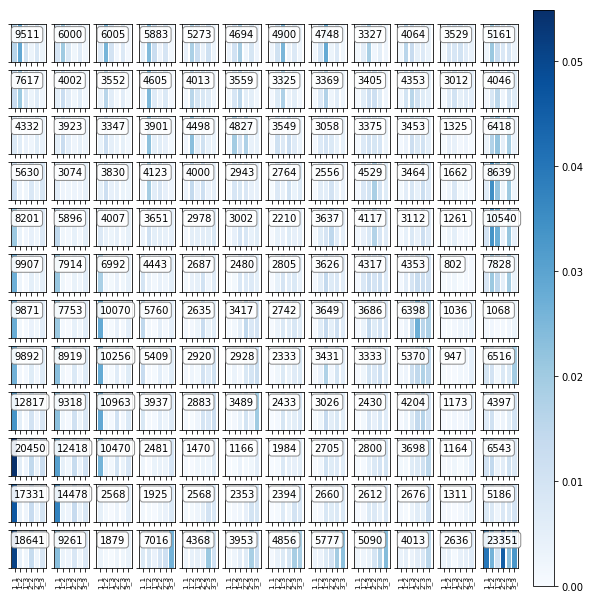

In [77]:
book, counts = pink.attribute_heatmap(mode='train', plot=False, realisations=100)
label_plot(book, get_shape(book), color_map='Blues', weights=counts, xtick_rotation=90, count_text=True, figsize=(10,10))

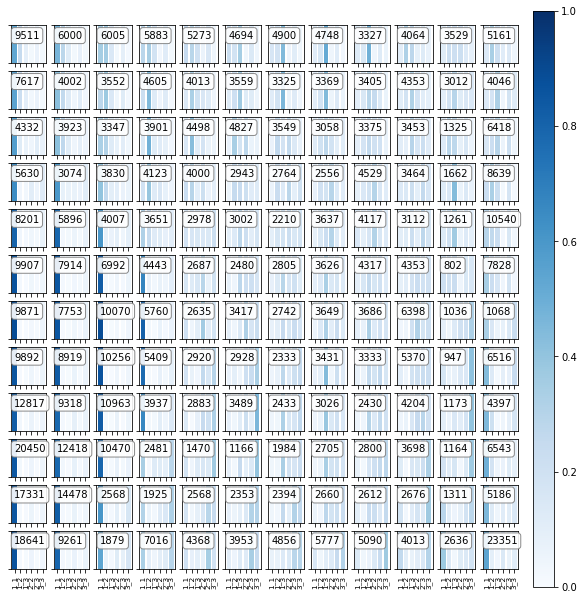

In [79]:
label_plot(book, get_shape(book), color_map='Blues', xtick_rotation=90, count_text=True, figsize=(10,10))

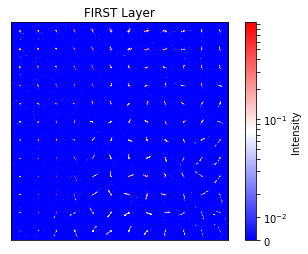

In [82]:
pink.show_som()

In [83]:
help(pink.show_som)

Help on method show_som in module catalog:

show_som(mode='train', channel=0, plt_mode='raw', color_map='bwr') method of catalog.Pink instance
    Method to plot the trained SOM, and associated plotting options
    
    mode - str or int
         Type passed through to _reterive_binary()
    channel - int
         The channel from the SOM to plot. Defaults to the first (zero-index) channel
    plt_mode - str
         Mode to print the SOM on. 
         `split` - Slice the neurons into their own subplot axes objects from the returned data
                   matrix from self.retrieve_som_data(). 
         `grid` - Plot each channel on its own subfigure
         `raw`  - Otherwise just plot it on screen. 
    color_map - str
        The name of the matplotlib.colormap that will be passed directly to matplotlib.pyplot.get_map()

